In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append("/home/files/feature_orthogonality")
from utils.session_config import setup_gpus

In [2]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
setup_gpus(memory_fraction=0.2)

1 Physical GPUs, 1 Logical GPUs


In [4]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, ReLU, BatchNormalization, GlobalAveragePooling2D
from utils.losses import L2_Orthogonal

In [5]:
model = tf.keras.models.load_model("mnist-3-cat-classifier.h5")

In [6]:
len(model.layers[2].weights)

0

In [7]:
for layer in model.layers:
    print(len(layer.get_weights()), "layer name : ", layer.name)

2 layer name :  conv2d
0 layer name :  re_lu
0 layer name :  max_pooling2d
2 layer name :  conv2d_1
0 layer name :  re_lu_1
0 layer name :  max_pooling2d_1
2 layer name :  conv2d_2
0 layer name :  re_lu_2
0 layer name :  global_average_pooling2d
2 layer name :  dense


In [8]:
model.layers[0].__class__.__name__

'Conv2D'

In [9]:
conv = model.layers[3]

In [10]:
conv.get_weights()[0].shape

(3, 3, 16, 16)

In [11]:
conv.get_weights()[1].shape

(16,)

In [12]:
conv.input.shape

TensorShape([None, 13, 13, 16])

In [13]:
num_filters = conv.filters
num_filters

16

In [14]:
num_filters + conv.input.shape[1:]

TensorShape([16, 13, 13, 16])

In [15]:
input_layer = tf.keras.Input(conv.input.shape[1:]+[4])

In [16]:
input_layer

<tf.Tensor 'input_1:0' shape=(None, 13, 13, 16, 4) dtype=float32>

In [17]:
sub_features = tf.split(input_layer, 4 ,axis=-1)
sub_features

[<tf.Tensor 'split:0' shape=(None, 13, 13, 16, 1) dtype=float32>,
 <tf.Tensor 'split:1' shape=(None, 13, 13, 16, 1) dtype=float32>,
 <tf.Tensor 'split:2' shape=(None, 13, 13, 16, 1) dtype=float32>,
 <tf.Tensor 'split:3' shape=(None, 13, 13, 16, 1) dtype=float32>]

In [18]:
outputs = []
for sub_feature in sub_features:
    sub_feature = tf.squeeze(sub_feature, axis=-1)
    outputs.append(Conv2D(1, (3,3))(sub_feature))
layer_output = tf.concat(outputs, axis=-1)

In [19]:
layer_output.shape

TensorShape([None, 11, 11, 4])

In [20]:
x = tf.keras.Model(inputs=input_layer, outputs=[outputs, layer_output])

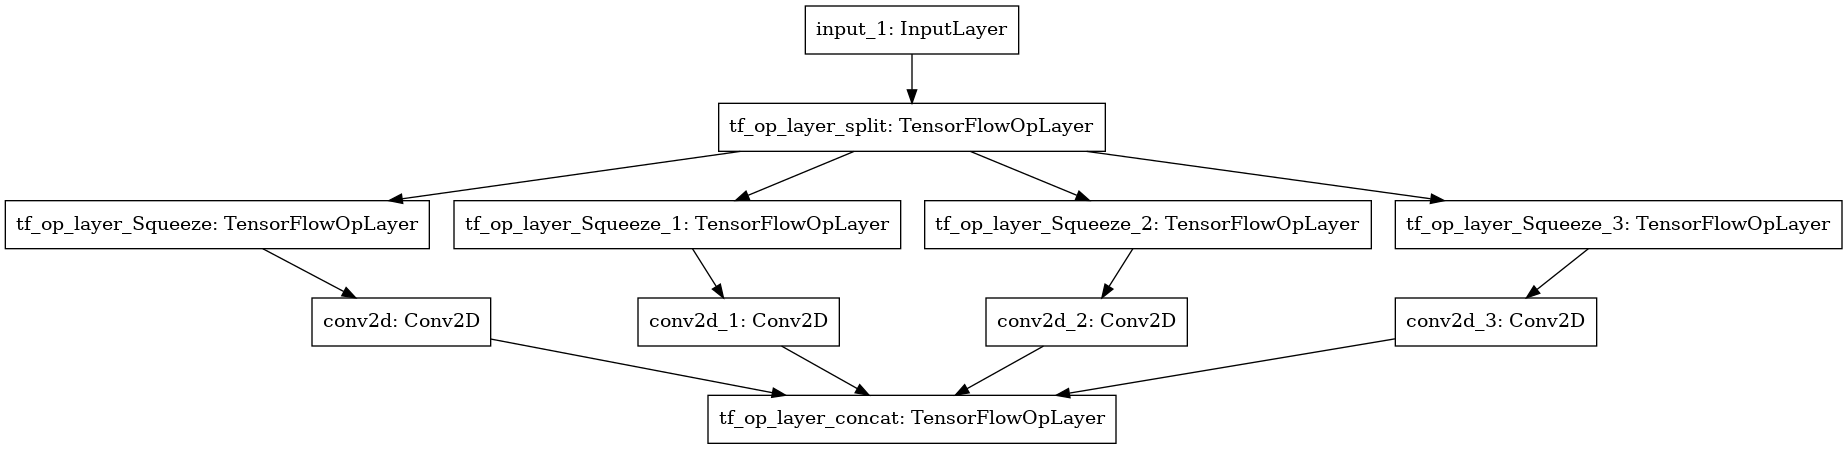

In [21]:
tf.keras.utils.plot_model(x)

In [25]:
x.layers[-2].get_weights()[0].shape

(3, 3, 16, 1)

In [26]:
conv.get_weights()[0].shape

(3, 3, 16, 16)

In [28]:
conv.get_weights()[0][0].shape

(3, 16, 16)

In [40]:
x.layers[-2].set_weights([conv.get_weights()[0][...,0:1], conv.get_weights()[1][0:1]])

In [37]:
conv.get_weights()[0][...,0:1].shape

(3, 3, 16, 1)

In [39]:
conv.get_weights()[1][0:1].shape

(1,)

In [ ]:
model.layers[-1].__class__.__name__

In [ ]:
fc = model.layers[-1]

In [ ]:
num_perceptrons = fc.units

In [ ]:
input_layer = tf.keras.Input(fc.units + fc.input.shape[1:])
input_layer

In [ ]:
sub_features = tf.split(input_layer, num_perceptrons ,axis=1)
sub_features

In [ ]:
weight_shape = fc.get_weights()[0].shape[0]

In [ ]:
weight_shape

In [ ]:
outputs = []
for sub_feature in sub_features:
    sub_feature = tf.squeeze(sub_feature, axis=1)
    outputs.append(Dense(1)(sub_feature))
layer_output = tf.concat(outputs, axis=-1)

In [ ]:
layer_output

In [ ]:
x = tf.keras.Model(inputs=input_layer, outputs=[outputs, layer_output])
tf.keras.utils.plot_model(x)

In [ ]:
def convert_convolution(conv):
    num_filters = conv.filters
    weight_shape = conv.get_weights()[0].shape[:-2]
    input_layer = tf.keras.Input(num_filters + conv.input.shape[1:]) # [B,N,H,W,D]. B:batch size, N:feature maps of previous layer
    sub_features = tf.split(input_layer, num_filters ,axis=1) #[B,1,H,W,D] x N
    
    outputs = []
    for sub_feature in sub_features:
        sub_feature = tf.squeeze(sub_feature, axis=1)
        outputs.append(Conv2D(1, weight_shape)(sub_feature))
    layer_output = tf.concat(outputs, axis=-1)    
    x = tf.keras.Model(inputs=input_layer, outputs=[layer_output, outputs])
    return x
def convert_dense(fc)
    num_perceptrons = fc.units
    weight_shape = fc.get_weights()[0].shape[:-2]
    input_layer = tf.keras.Input(fc.units + fc.input.shape[1:]) # [B,N,D]. B:batch size, N:feature maps of previous layer
    sub_features = tf.split(input_layer, num_filters ,axis=1) #[B,1,D] x N
    
    outputs = []
    for sub_feature in sub_features:
        sub_feature = tf.squeeze(sub_feature, axis=1)
        outputs.append(Dense(1)(sub_feature))
    layer_output = tf.concat(outputs, axis=-1)
    x = tf.keras.Model(inputs=input_layer, outputs=[layer_output, outputs])
    return x

def convert_to_separate_perceptrons(layer):
    layer_type = layer.__class__.name
    if layer_type == 'Conv2D':
        converted = convert_convolution(layer)
    elif layer_type == 'Dense':
        converted = convert_dense(layer)
    else:
        raise NotImplementedError("This type of layer is not implemented yet.")

In [ ]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, ReLU, BatchNormalization, GlobalAveragePooling2D

# def etching_weighted_layer(layer, input_tensor):
#     if layer.__class__name == 'Conv2D':
#         _layer = etching_weighted_conv2d(layer, input_tensor)
#     return _layer

# def etching_weighted_conv2d(layer):
#     input_shape = layer.input.shape[1:]
#     input_layer = InputLayer(input_shape)
    
#     weights = layer.get_weights()
#     kernel_shape = weights.shape[0]
#     bias_shape = weights.shape[1]
    
#     for w,b in 
    
    
    

In [ ]:
conv.filters